In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [2]:
# Hiển thị số thập phân thay cho science math number
np.set_printoptions(suppress=True)

In [3]:
data = pd.read_csv('../../Data/ageinc_g.csv', index_col=0)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   income  1000 non-null   int64 
 1   age     1000 non-null   int64 
 2   gender  1000 non-null   object
dtypes: int64(2), object(1)
memory usage: 31.2+ KB


In [5]:
data.head()

,income,age,gender
0,101743,58,Female
1,49597,27,Female
2,36517,52,Male
3,33223,49,Male
4,72994,53,Female


In [6]:
# Kiểm tra dữ liệu null
print(data.isnull().sum())

income    0
age       0
gender    0
dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_w

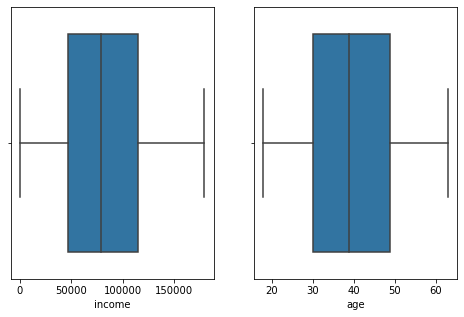

In [7]:
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
sns.boxplot(data.income, orient="v")
plt.subplot(1, 2, 2)
sns.boxplot(data.age, orient="v")
plt.show()

In [8]:
data =pd.get_dummies(data, drop_first=True)

In [9]:
data.head()

,income,age,gender_Male
0,101743,58,0
1,49597,27,0
2,36517,52,1
3,33223,49,1
4,72994,53,0


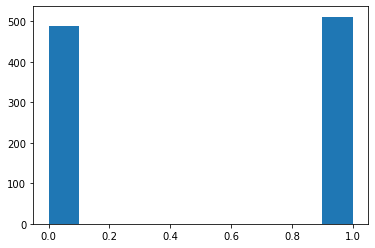

In [10]:
plt.hist(data.gender_Male)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


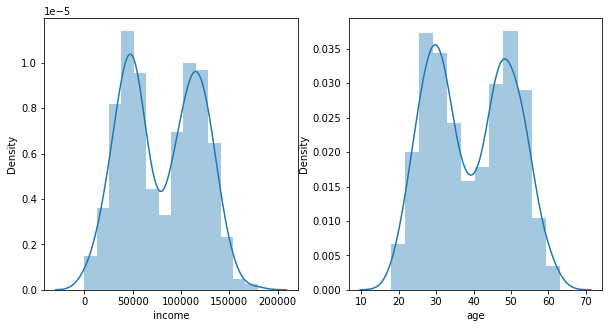

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
sns.distplot(data.income)
plt.subplot(1, 2, 2)
sns.distplot(data.age)
plt.show()

In [12]:
data.skew()

income         0.028753
age            0.049110
gender_Male   -0.044077
dtype: float64

In [13]:
data.kurtosis()

income        -1.210079
age           -1.262649
gender_Male   -2.002065
dtype: float64

In [14]:
mmScaler = MinMaxScaler()
mmScaler.fit(data[['income', 'age']])
data_sub = mmScaler.transform(data[['income', 'age']])

In [15]:
data_sub

array([[0.56746461, 0.88888889],
       [0.27662387, 0.2       ],
       [0.20367107, 0.75555556],
       ...,
       [0.23538434, 0.37777778],
       [0.0946769 , 0.28888889],
       [0.69080393, 0.57777778]])

In [16]:
data_sub_min_max_scaler = pd.DataFrame(data_sub, columns=['mm_income', 'mm_age'])
data = pd.concat([data.reset_index(drop=True), data_sub_min_max_scaler], axis=1)

In [17]:
data.head()

,income,age,gender_Male,mm_income,mm_age
0,101743,58,0,0.567465,0.888889
1,49597,27,0,0.276624,0.200000
2,36517,52,1,0.203671,0.755556
3,33223,49,1,0.185299,0.688889
4,72994,53,0,0.407119,0.777778


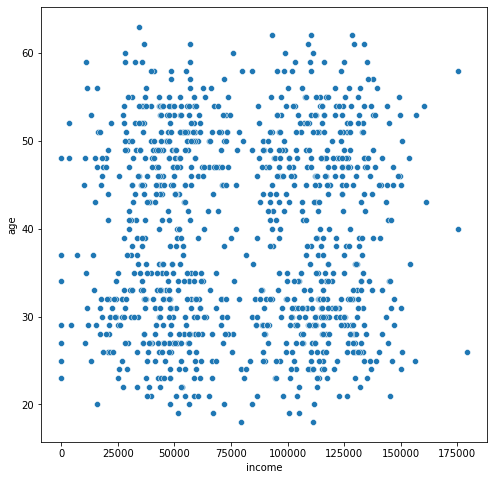

In [18]:
# Trực quan hóa dữ liệu để có cái nhìn ban đầu về phân nhóm
# Income & Age
plt.figure(figsize=(8, 8))
sns.scatterplot(data=data, x='income', y='age')
plt.show()

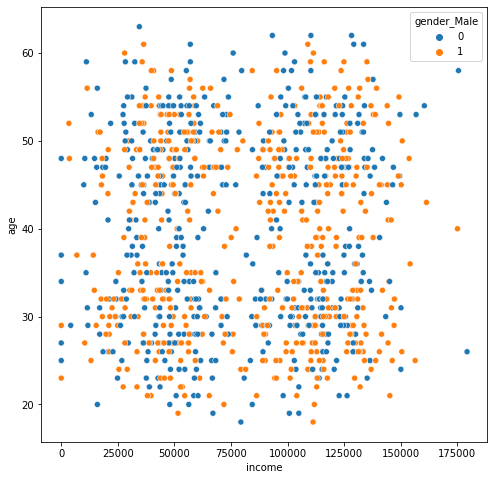

In [19]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=data, x='income', y='age', hue='gender_Male')
plt.show()

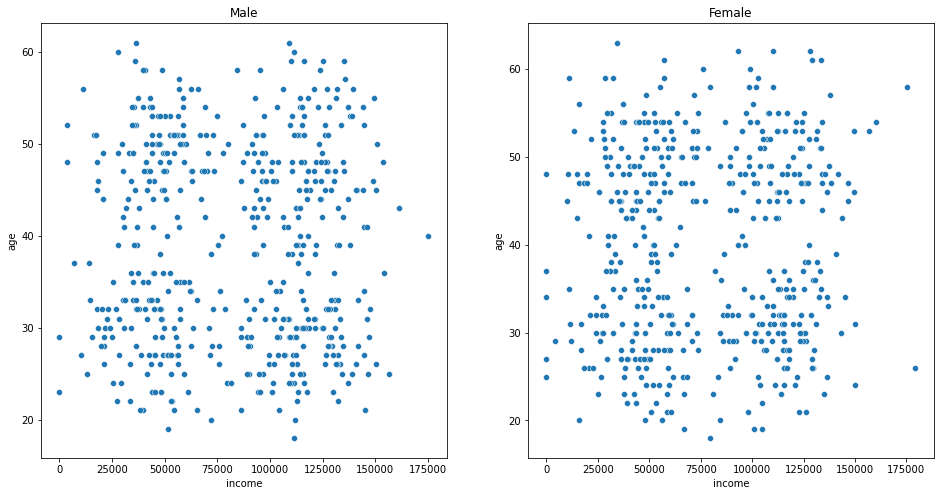

In [20]:
# Only Male
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data[data['gender_Male']==1], x='income', y='age')
plt.title('Male')
plt.subplot(1, 2, 2)
sns.scatterplot(data=data[data['gender_Male']==0], x='income', y='age')
plt.title('Female')
plt.show()

### Nhận xét:
* Cả nam và nữ đều phân bố như nhau

In [21]:
data_male = data.where(data['gender_Male']==1, axis=0).dropna()
data_female = data.where(data['gender_Male']==0, axis=0).dropna()

## Phân cụm theo: mm_income, mm_age

In [22]:
# Chọn k
distortions = [] # Chứa WSSE tương ứng
K = range(1, 8)
for k in K:
    kmeanModel = KMeans(n_clusters=k) # Số cụm
    kmeanModel.fit(data[['mm_income', 'mm_age']])
    distortions.append(sum(np.min(cdist(data[['mm_income', 'mm_age']],
                                        kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data[['mm_income', 'mm_age']].shape[0])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


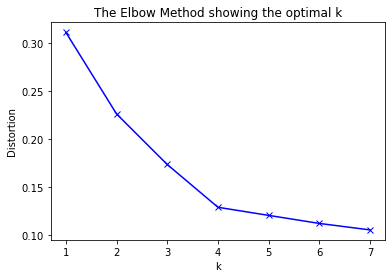

In [23]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Chọn K=4 vì từ 4 lỗi giảm đi nhỏ và mịn

In [25]:
# Áp dụng k=4
kmeans = KMeans(n_clusters=4)
kmeans.fit(data[['mm_income', 'mm_age']])

KMeans(n_clusters=4)

In [27]:
centroids =kmeans.cluster_centers_
labels = kmeans.labels_
print('Centroids in min-max scale:')
print(centroids)
print('Centroids in normal:')
normal_centroids = mmScaler.inverse_transform(centroids)
print(normal_centroids)
print(labels)

Centroids in min-max scale:
[[0.25925224 0.69644097]
 [0.64257984 0.26106804]
 [0.64809667 0.6977591 ]
 [0.24372937 0.25833333]]
Centroids in normal:
[[ 46482.37109375     49.33984375]
 [115210.70930233     29.74806202]
 [116199.84453782     49.39915966]
 [ 43699.21370968     29.625     ]]
[2 3 0 0 0 3 3 1 3 0 3 3 3 2 2 0 1 1 3 0 3 1 2 2 3 1 2 3 2 1 3 3 3 1 1 1 3
 3 0 2 0 0 2 1 1 1 2 2 1 3 1 0 2 3 0 3 3 3 1 3 2 0 1 1 3 1 0 1 2 1 0 1 1 2
 0 0 3 1 1 2 2 3 1 0 1 0 0 0 0 1 0 3 0 1 3 3 1 0 0 0 3 1 0 2 0 3 1 0 0 0 3
 2 2 3 1 0 2 1 3 0 2 3 1 3 0 3 1 3 3 2 1 3 0 1 2 0 1 3 2 3 0 3 0 1 3 0 2 1
 1 3 1 3 1 0 3 3 1 3 1 2 2 1 2 1 2 3 3 2 1 3 1 0 1 2 0 0 2 2 1 1 0 3 1 3 2
 1 1 2 2 1 1 0 3 3 3 3 2 1 2 0 2 0 0 3 0 2 2 0 0 0 0 0 2 2 0 3 1 3 2 0 1 1
 3 1 1 2 0 3 0 2 2 0 2 1 3 1 3 2 3 2 2 0 3 1 0 2 2 3 3 1 3 3 3 0 0 0 1 1 2
 1 1 3 2 1 3 2 2 3 1 0 0 1 3 2 2 2 3 3 2 2 2 1 3 2 1 2 0 3 0 3 3 0 2 1 3 1
 0 1 2 3 1 0 1 2 3 0 0 1 3 0 1 1 0 0 0 3 1 3 2 0 0 3 2 0 0 3 2 0 0 0 0 3 1
 1 0 3 3 3 2 2 3 1 1 0 0 3 2 3 0 3